### Fetal Immune - Splitting and clustering for annotation

In this notebook we generate a coarse clustering of the batch corrected Fetal Immune Atlas to split into broad cell lineages on which we will do detailed re-annotation. 

In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from time import time
from datetime import datetime
import seaborn as sns

### Load data

In [2]:
adata = sc.read_h5ad("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.h5ad")

In [3]:
## Here I am adding the labels post-hoc
# These will be already saved in the anndata in future iterations
new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv", index_col=0)
# new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210112.clustering.obs.csv", index_col=0)
adata.obs = new_obs[new_obs.doublet_scores < 0.4]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
cl_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.clustering.obs.csv", index_col=0)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10,17,18,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
cl_obs.index = adata.obs_names

In [6]:
adata.obs = pd.concat([adata.obs, cl_obs.loc[adata.obs_names][["leiden_100", "leiden_150"]]],axis=1)

### Clustering

In [178]:
start=datetime.now()
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_150', n_iterations=5)
lei_time = datetime.now()-start
print("Leiden runtime: ", str(lei_time))

Leiden runtime:  0:26:28.836843


In [88]:
start=datetime.now()
sc.tl.leiden(adata, resolution=1, key_added='leiden_100', n_iterations=5)
lei_time = datetime.now()-start
print("Leiden runtime: ", str(lei_time))

Leiden runtime:  0:25:59.607226


In [7]:
adata.obs["leiden_150"]=adata.obs["leiden_150"].astype("category")
adata.obs["leiden_100"]=adata.obs["leiden_100"].astype("category")

... storing 'Sample' as categorical
... storing 'donor' as categorical
... storing 'organ' as categorical
... storing 'method' as categorical
... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'name' as categorical
... storing 'batch' as categorical
... storing 'bbk' as categorical
... storing 'uniform_label' as categorical
... storing 'uniform_label_expanded_merged' as categorical
... storing 'uniform_label_lvl0' as categorical
... storing 'Sample.lanes' as categorical
... storing 'Sort_id' as categorical
... storing 'sex' as categorical
... storing 'Processing_method' as categorical


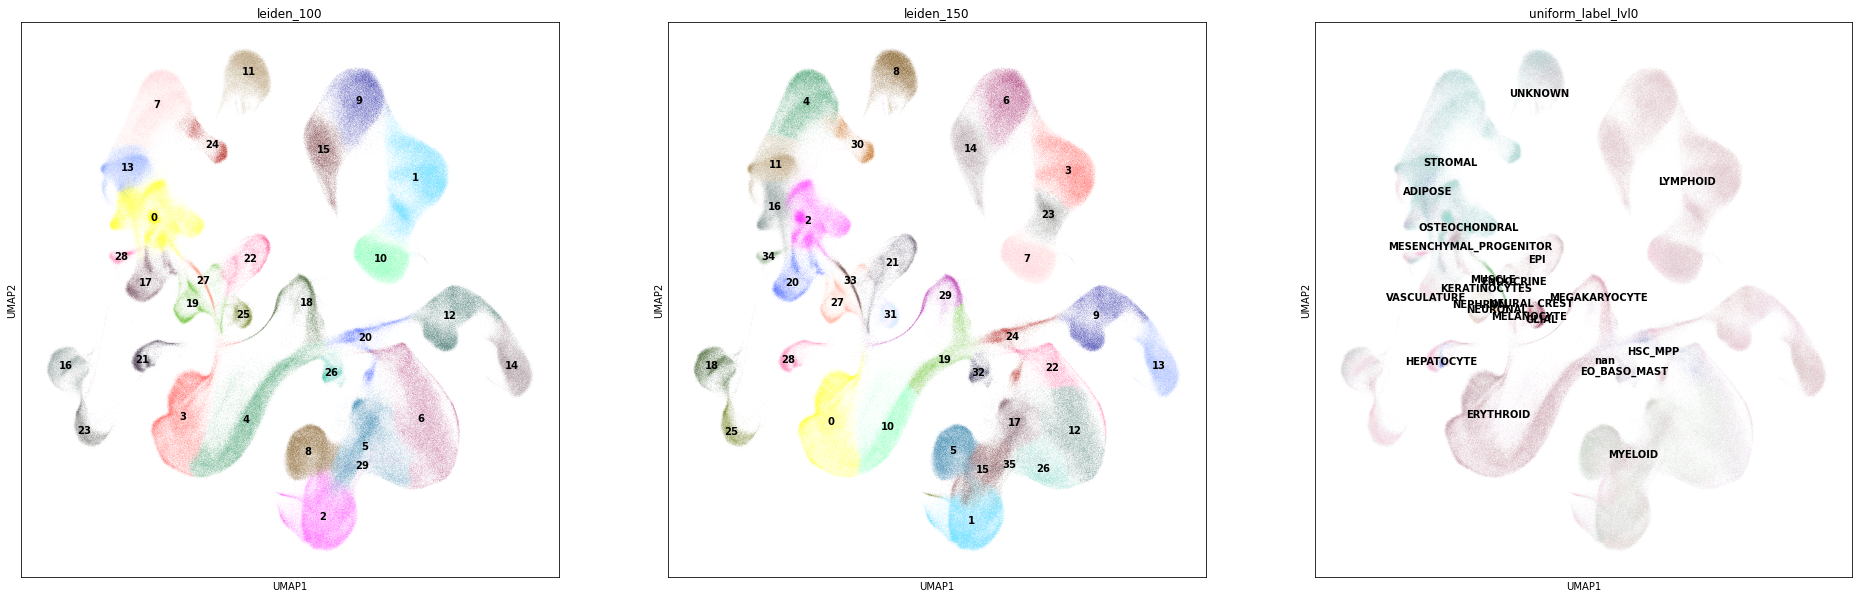

In [8]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=['leiden_100', "leiden_150",'uniform_label_lvl0'], legend_loc="on data")

Fix wrong labelling of ENTEROCYTES and typo

In [9]:
obs_df = adata.obs
obs_df["uniform_label_expanded_merged"] = obs_df["uniform_label_expanded_merged"].astype("str")
obs_df.loc[adata.obs_names[np.where(adata.obs.uniform_label=="ENTEROCYTE")], "uniform_label_expanded_merged"] = "ENTEROCYTE"
obs_df.loc[adata.obs_names[np.where(adata.obs.uniform_label=="LMPP")],"uniform_label_expanded_merged"] = "LYMPHOID PROGENITOR"

In [10]:
adata.obs = obs_df

### Propagate labels to unannotated cells

Make KNN graph with bigger k

In [237]:
def _propagate_labels(adata, anno_col):
    anno_nans = (adata.obs[anno_col]=="nan").values
    nan2labelled_conns = adata.obsp["connectivities"][:,anno_nans]
    ## Get KNN edges between nans and all cells
    nan2labelled_conns[nan2labelled_conns.nonzero()] = 1
    
    ## Make dummy matrix of labels
    lab_dummies = pd.get_dummies(adata.obs[anno_col])
    lab_unique = lab_dummies.columns
    lab = lab_dummies.to_numpy().T
    
    ## Calculate label probability based on labels of neighbours
    class_prob =  lab @ nan2labelled_conns
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    
    ## Pick label with max prob
    new_labs = lab_unique[class_prob[:,lab_unique!="nan"].argmax(1)].to_numpy()
    max_prob = class_prob[:,lab_unique!="nan"].max(1)
    new_labs[max_prob==0] = np.nan # exclude cells with no neighbour != nan

    adata.obs[anno_col + "_propagated"] = adata.obs[anno_col]
    adata.obs[anno_col + "_propagated"].loc[anno_nans] = new_labs

In [238]:
_propagate_labels(adata, anno_col="uniform_label")

In [246]:
_propagate_labels(adata, anno_col="uniform_label_lvl0")

In [248]:
_propagate_labels(adata, anno_col="uniform_label_expanded_merged")
_propagate_labels(adata, anno_col="uniform_label_expanded")

KeyError: 'uniform_label_expanded'

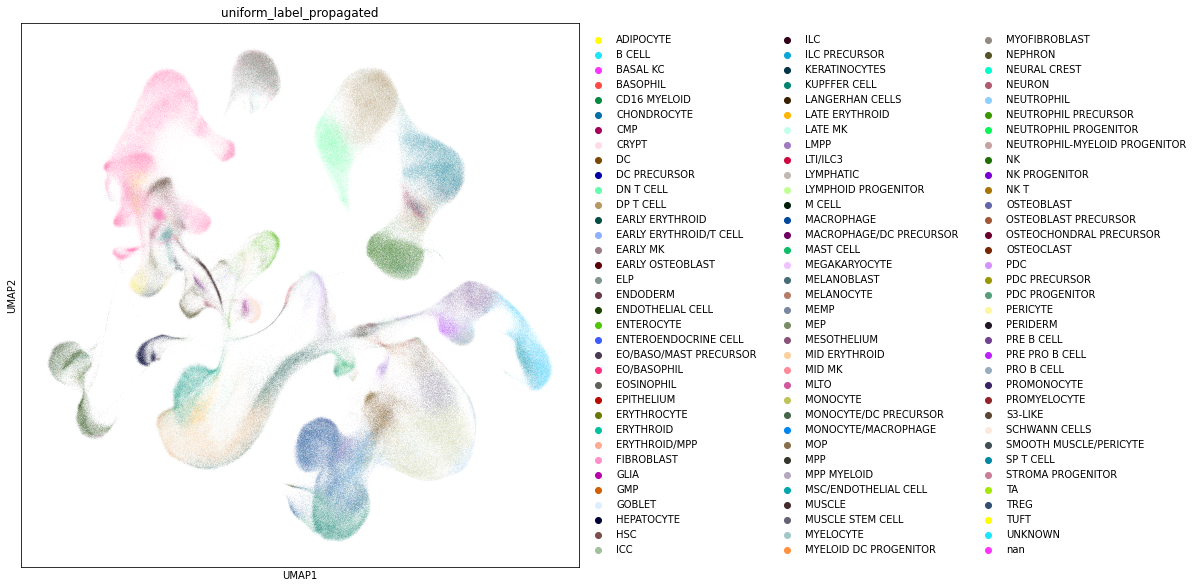

In [244]:
sc.pl.umap(adata, color=["uniform_label_propagated"],palette=sc.plotting.palettes.default_102)

Trying to set attribute `.uns` of view, copying.


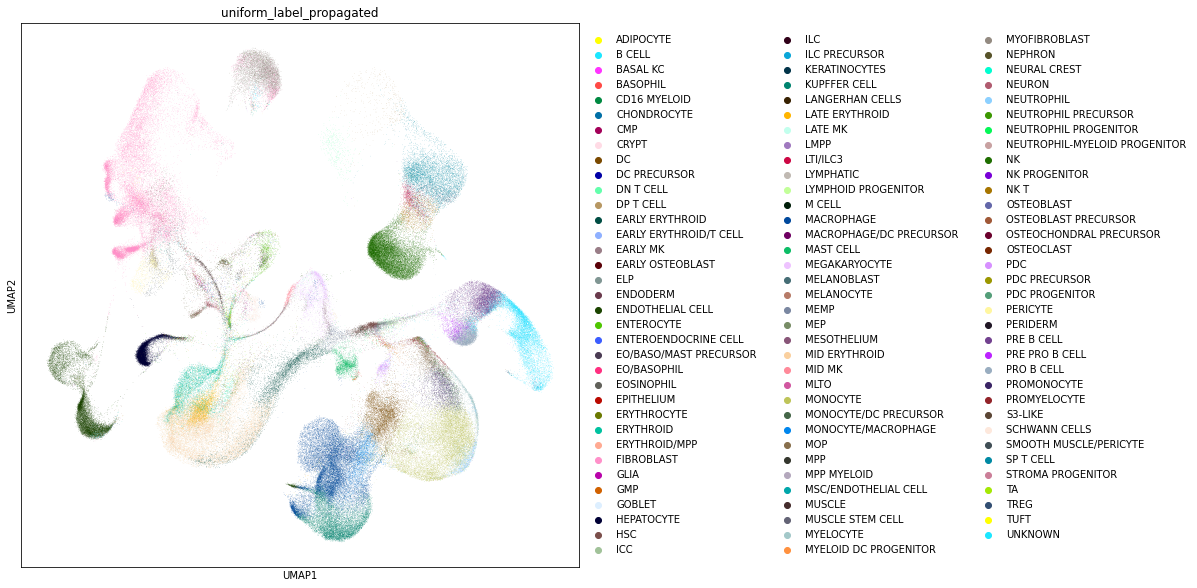

In [245]:
sc.pl.umap(adata[adata.obs["uniform_label"]=="nan"], color=["uniform_label_propagated"],palette=sc.plotting.palettes.default_102)

### Add putative labels based on the most abundant cells in clusters

In [249]:
adata.obs['leiden_150'] = [str(x) for x in adata.obs['leiden_150']]

In [250]:
## Add predicted lvl0 label based on most frequent cell type
cl_counts = adata.obs.reset_index()[['uniform_label_lvl0_propagated', 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', 'uniform_label_lvl0_propagated']) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=['uniform_label_lvl0_propagated'])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

In [251]:
## Add predicted uniform label based on most frequent cell type
cl_counts = adata.obs.reset_index()[["uniform_label_expanded_merged_propagated", 'leiden_150','index']] \
    .dropna() \
    .groupby(['leiden_150', "uniform_label_expanded_merged_propagated"]) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['leiden_150'], index=["uniform_label_expanded_merged_propagated"])

cl_frac = (cl_counts/cl_counts.sum(0))
cl_frac.columns = ['index_' + str(x[1]) for x in cl_frac.columns]
max_cl = cl_frac.max()
top_3_ls = []
for cl in cl_frac.columns:
    top_3 = cl_frac[cl_frac.index!="nan"].nlargest(1, cl)[cl].index[0]
    top_3_ls.append(top_3)

pred_labels_df = pd.DataFrame(top_3_ls, columns=['leiden_150_pred_label'], index=[int(x.split("index_")[1]) for x in cl_frac.columns])

pred_labels_df.index = pred_labels_df.index.astype('str')
# pred_labels_df.loc[adata.obs['leiden_100']]['leiden_100_pred_label']

adata.obs['leiden_150_pred_label_expanded'] = pred_labels_df.loc[adata.obs['leiden_150']]['leiden_150_pred_label'].values

... storing 'leiden_150' as categorical
... storing 'leiden_150_pred_label' as categorical
... storing 'leiden_150_pred_label_expanded' as categorical
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
posx and posy should be finite values
posx and posy should be finite values


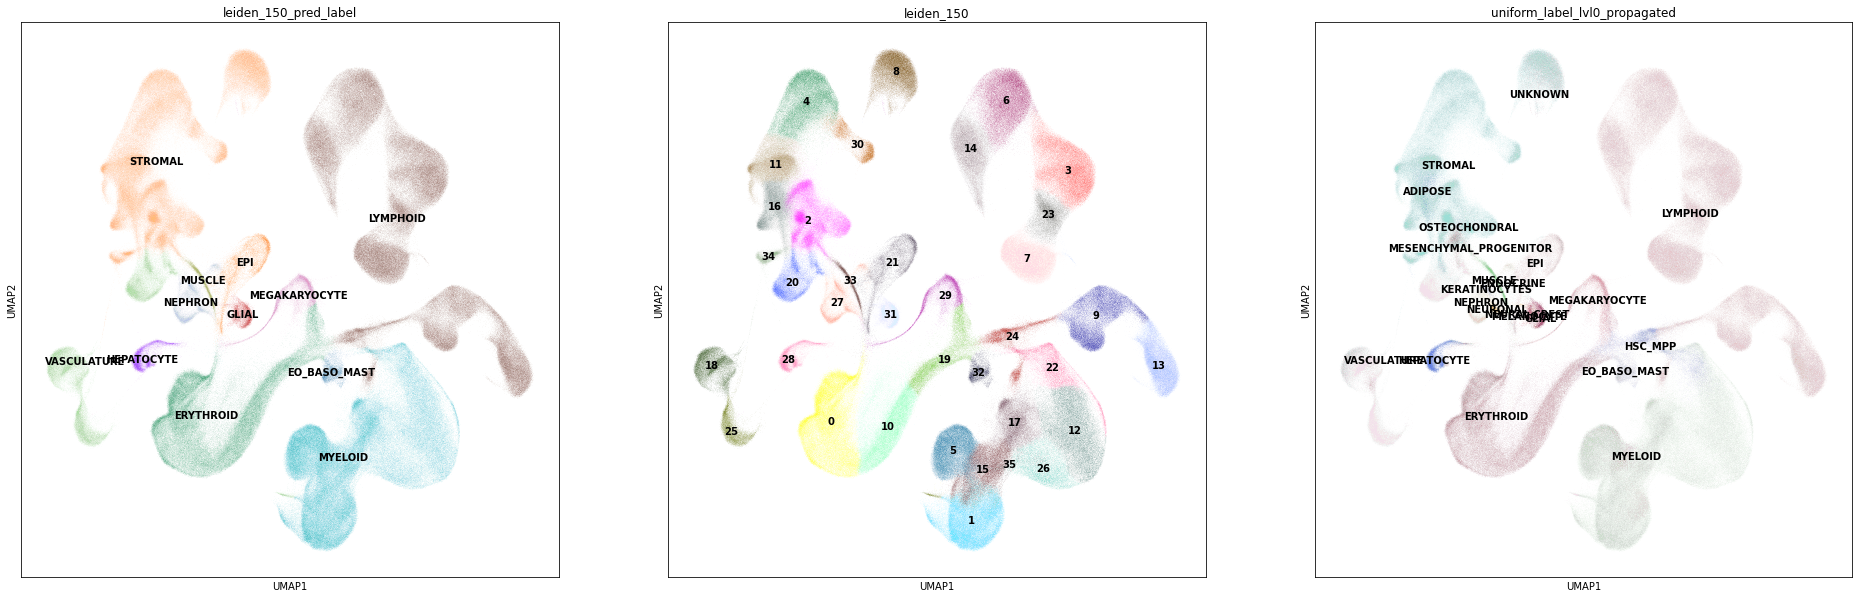

posx and posy should be finite values
posx and posy should be finite values


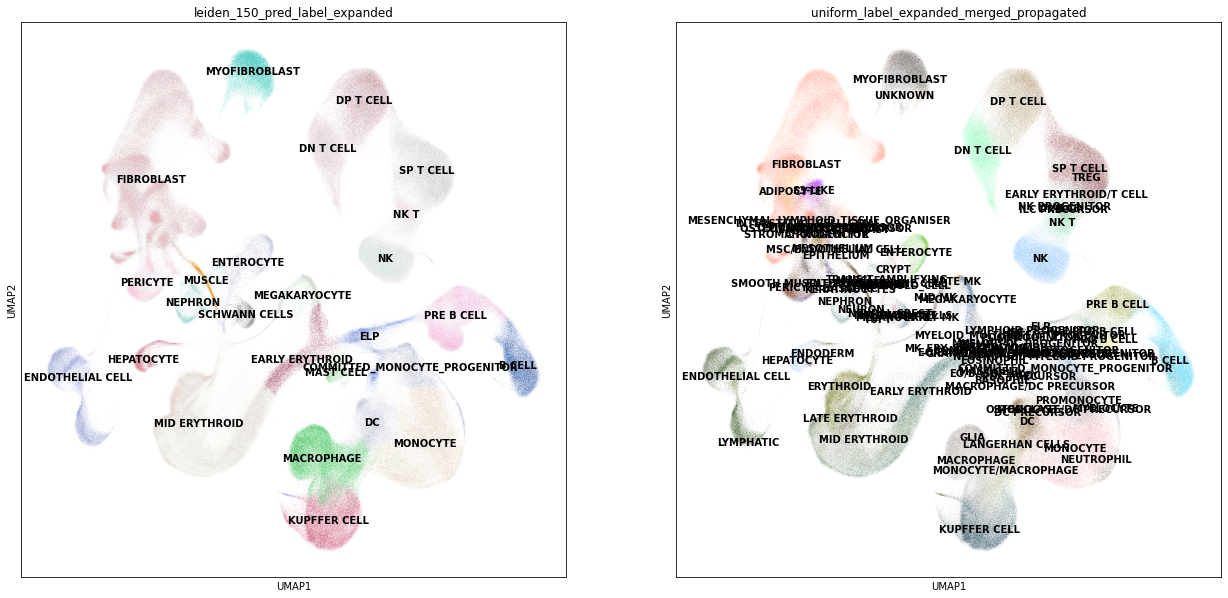

In [252]:
sc.pl.umap(adata, color=['leiden_150_pred_label','leiden_150', 'uniform_label_lvl0_propagated'], legend_loc="on data")
sc.pl.umap(adata, color=['leiden_150_pred_label_expanded',"uniform_label_expanded_merged_propagated"], legend_loc="on data")

Look at the progecitors

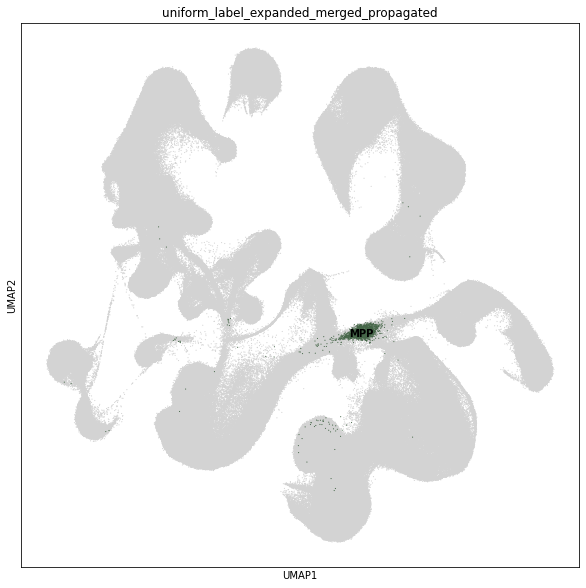

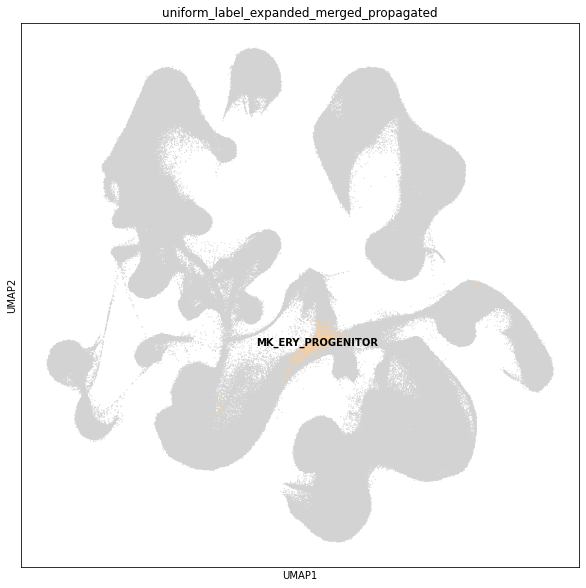

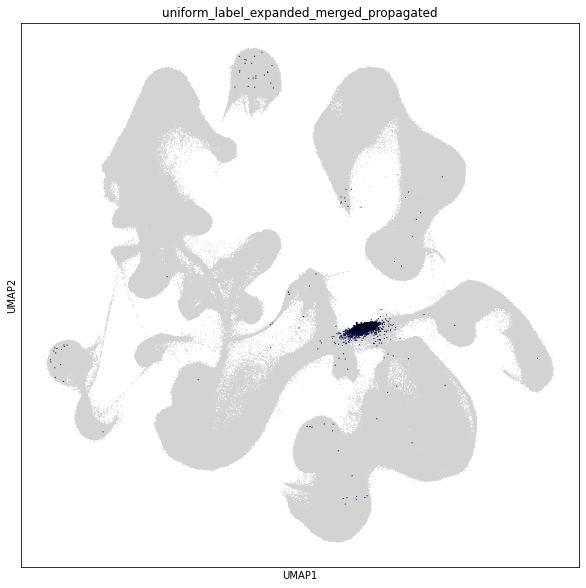

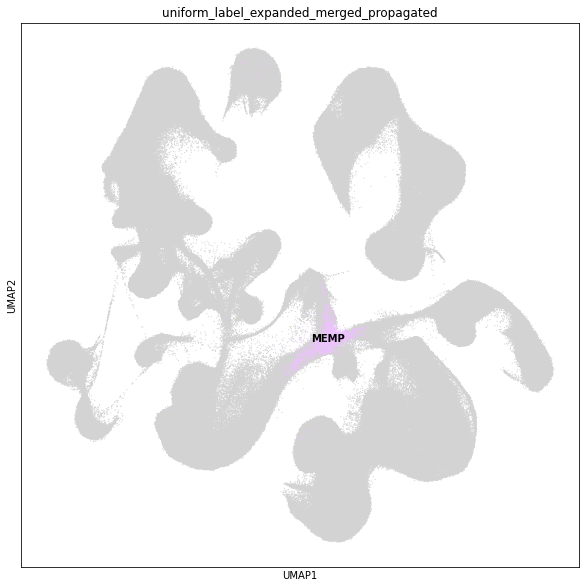

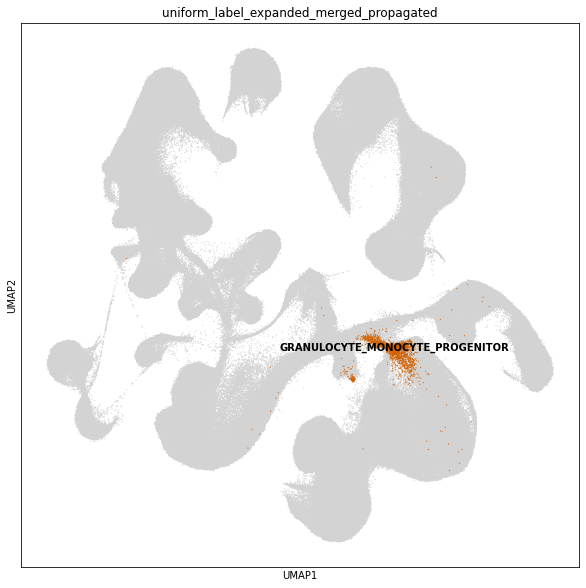

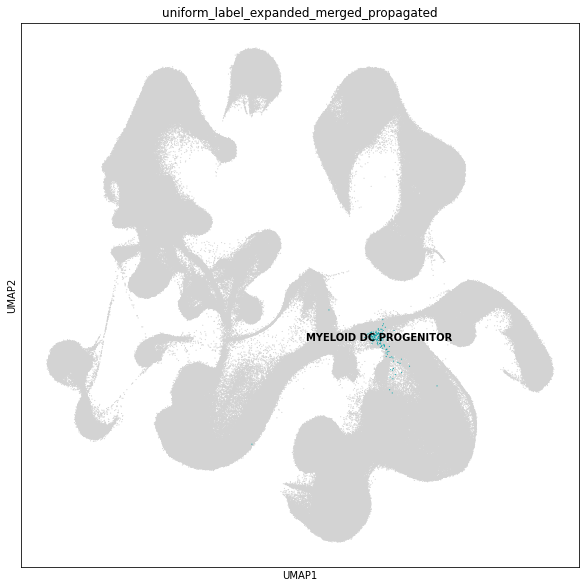

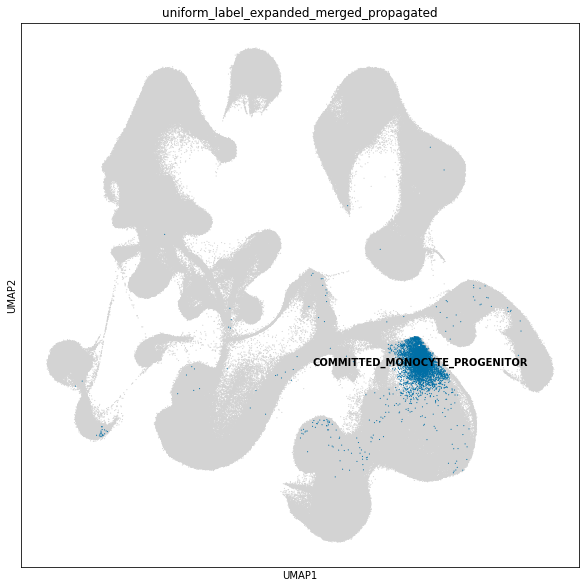

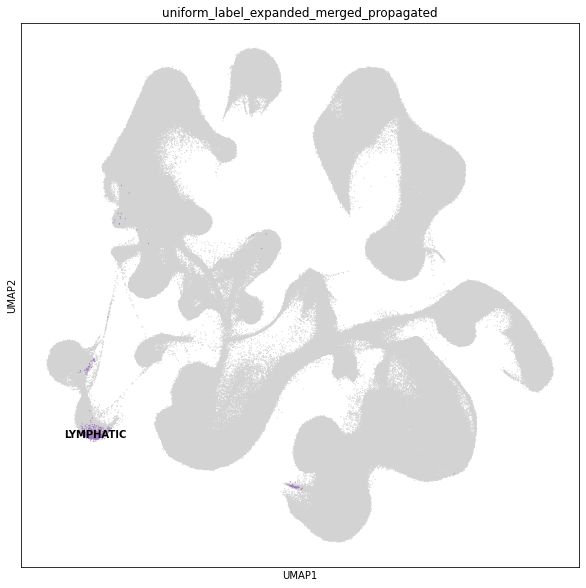

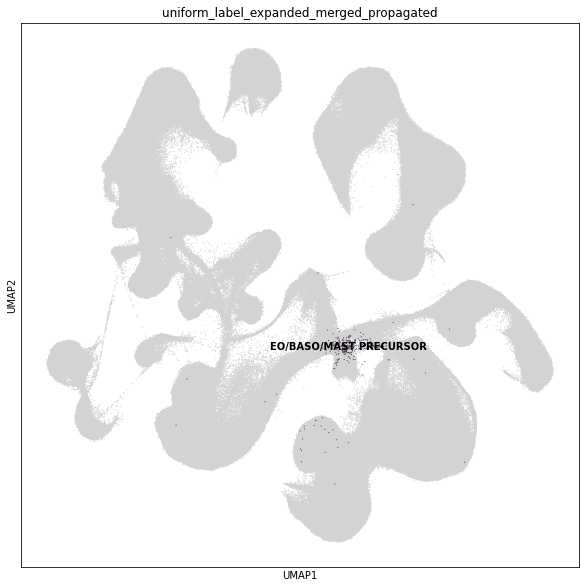

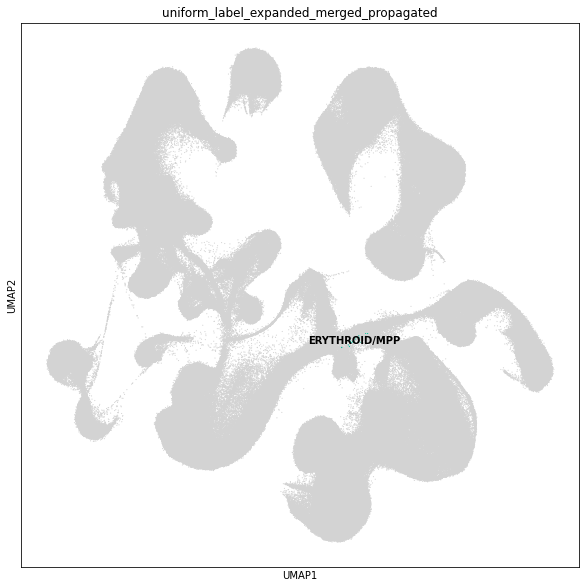

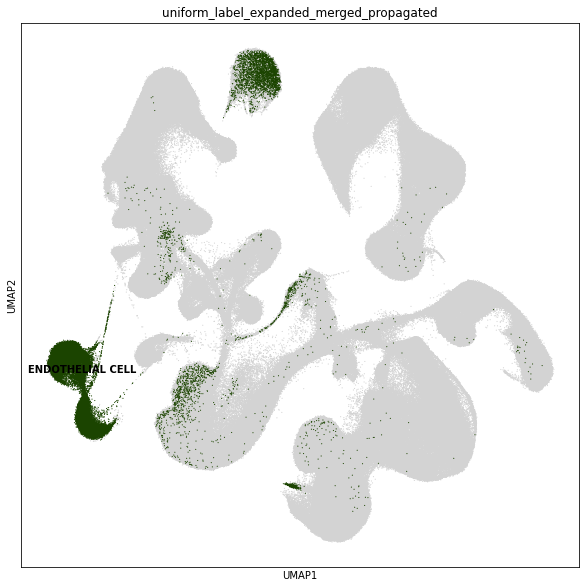

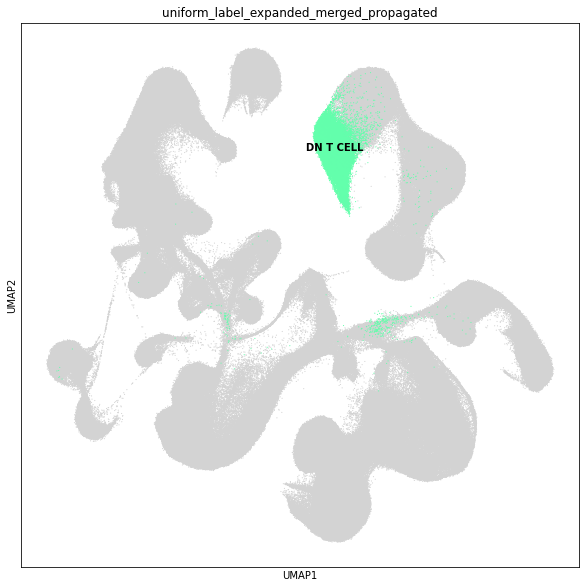

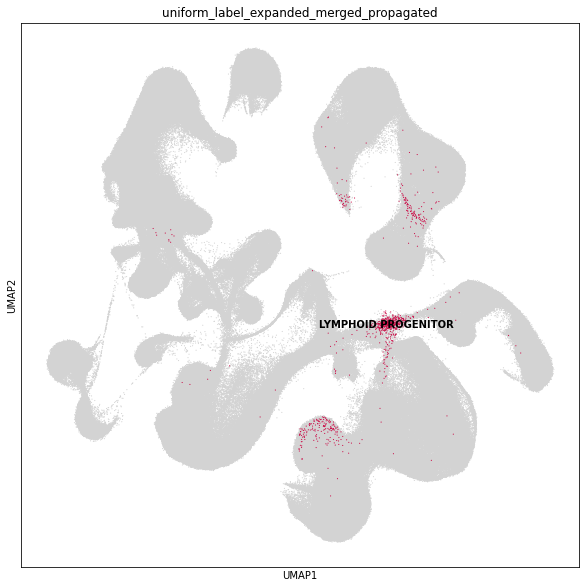

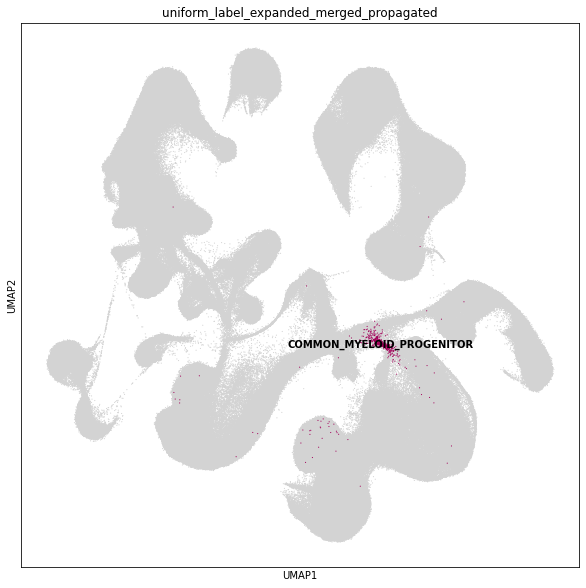

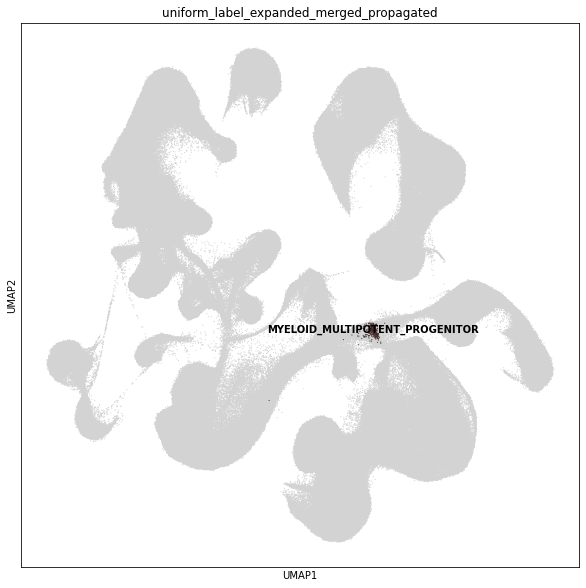

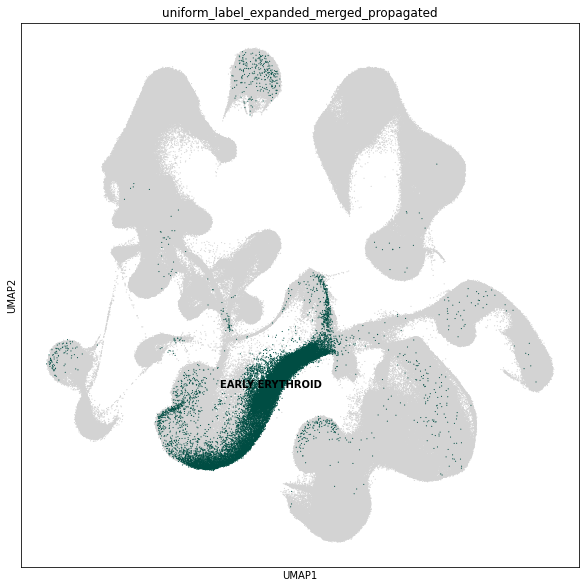

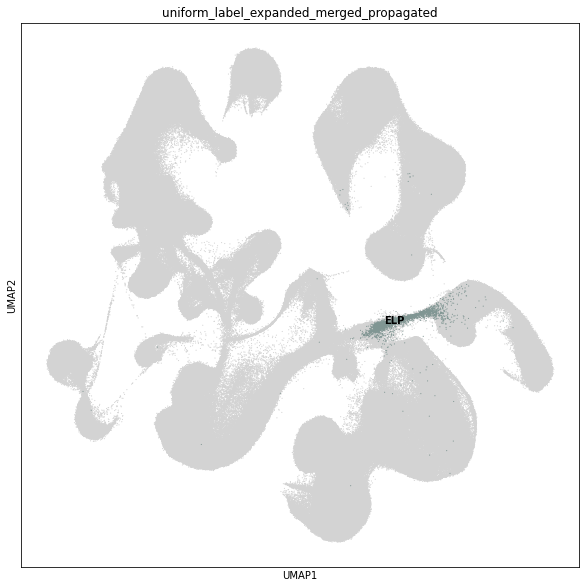

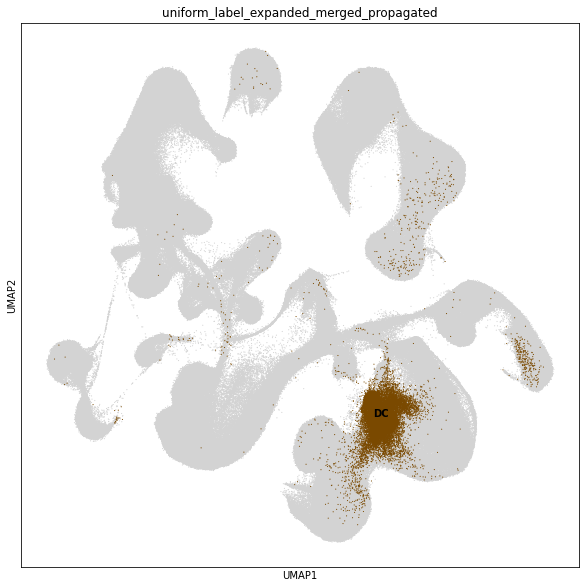

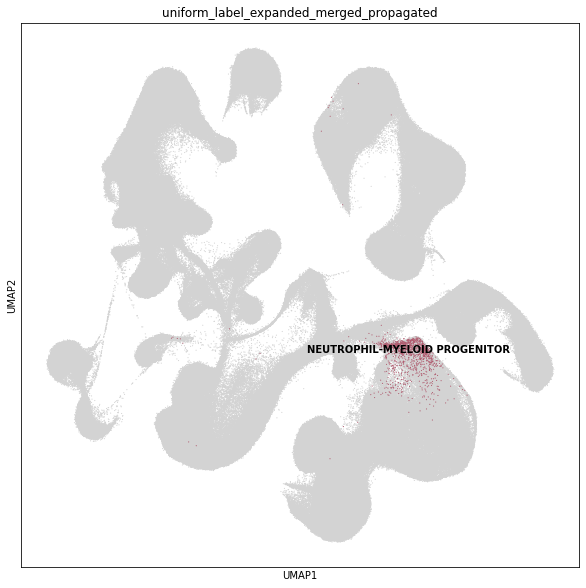

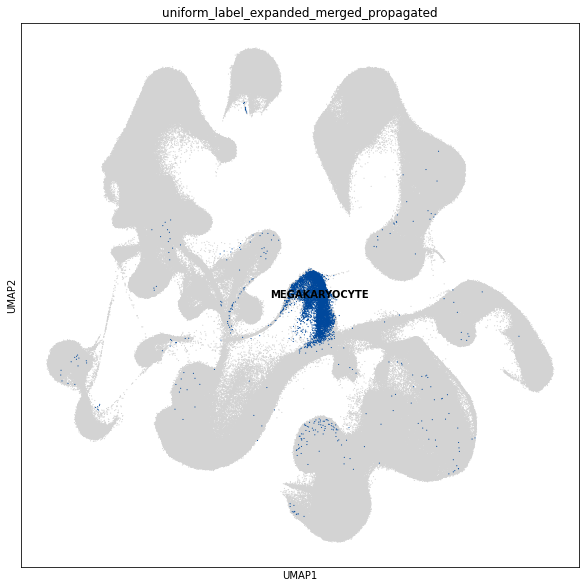

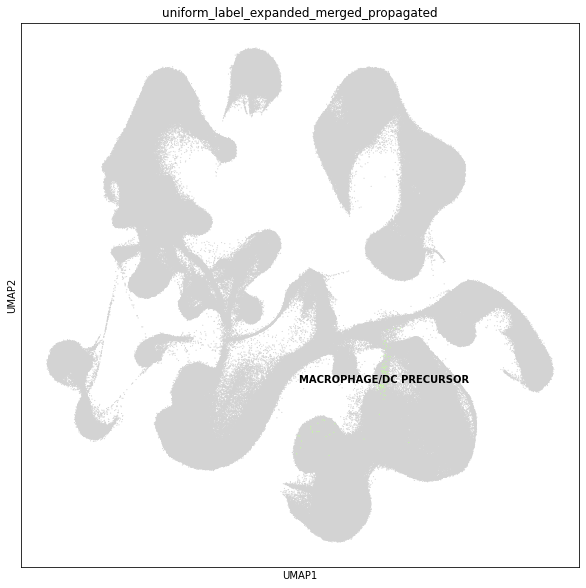

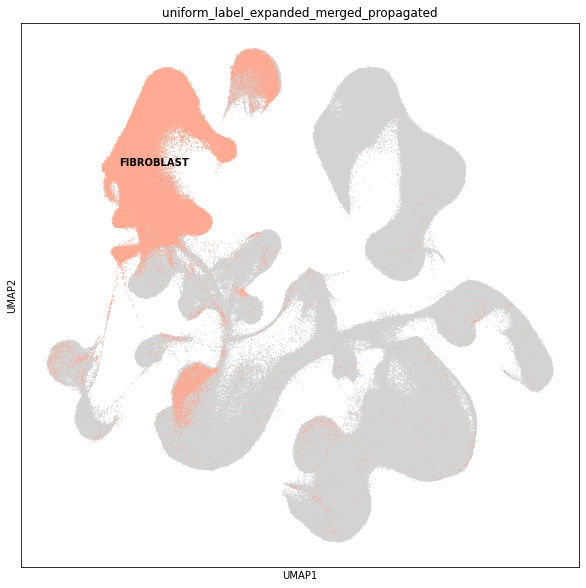

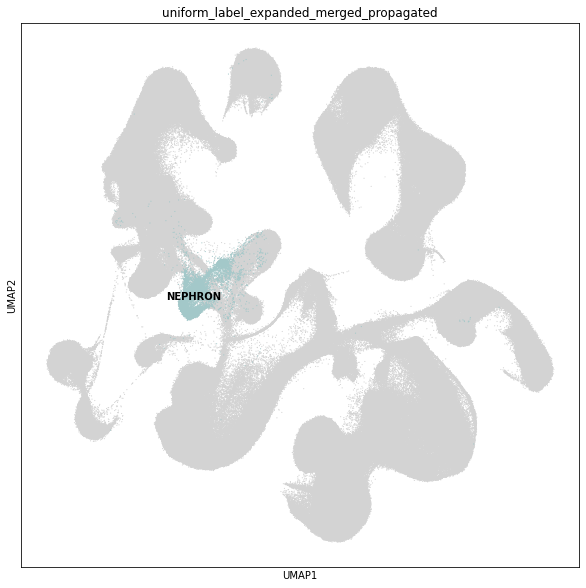

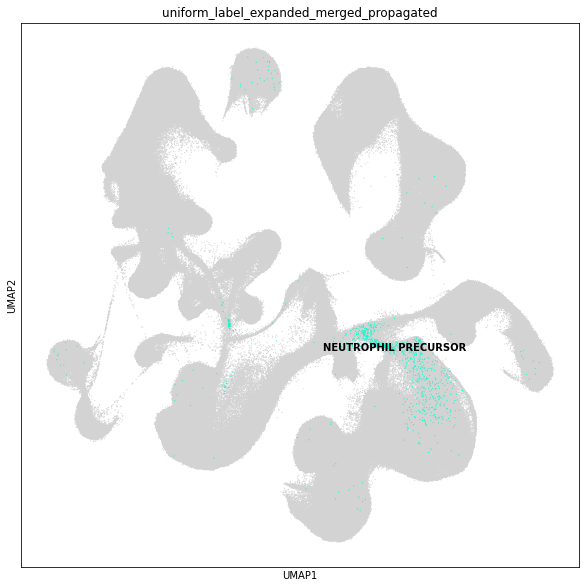

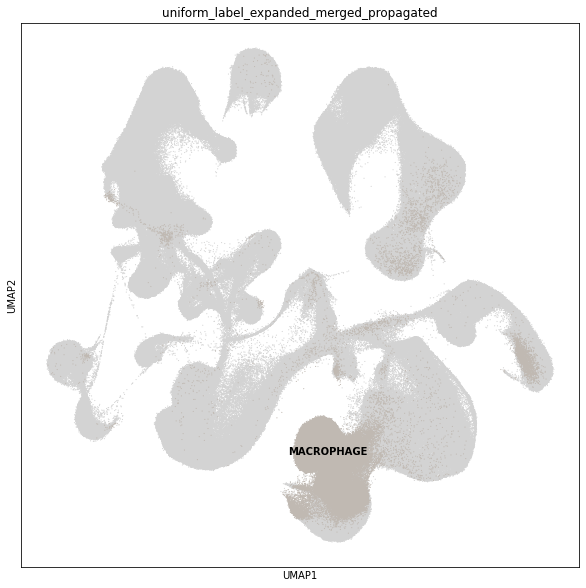

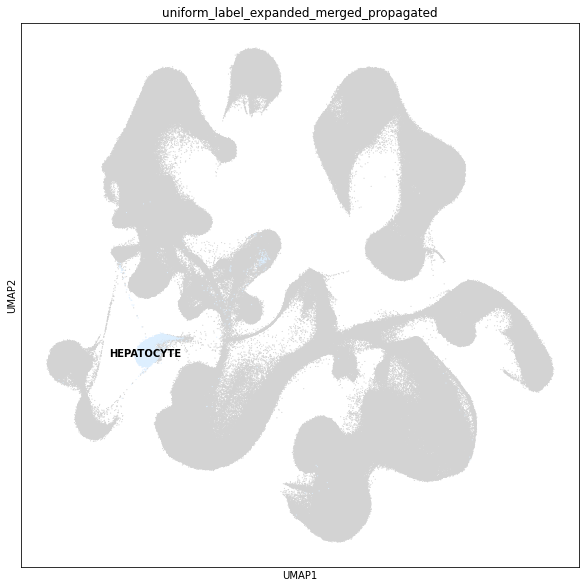

In [ ]:
for p in adata.obs[adata.obs["uniform_label_lvl0_propagated"]=="HSC_MPP"]["uniform_label_expanded_merged_propagated"].unique():
    sc.pl.umap(adata, color=["uniform_label_expanded_merged_propagated"], legend_loc="on data", 
           groups=[p], size=5,
          )

In [17]:
## Define hierarchy for making data subsets
pfi_splitting_df = adata.obs[['leiden_150_pred_label', 'leiden_150_pred_label_expanded']].drop_duplicates()
hsc_immune_lvl0 = ["LYMPHOID", "MYELOID", "HSC_MPP", "MEGAKARYOCYTE", "ERYTHROID", "EO_BASO_MAST"]
pfi_splitting_df["split_1"] = ["HSC_IMMUNE" if x in hsc_immune_lvl0 else "STROMA" for x in pfi_splitting_df['leiden_150_pred_label']]
pfi_splitting_df["split_2"] = [
    "MEM_PROGENITORS" if x in ["MEGAKARYOCYTE", "ERYTHROID"]
    else "MYELOID/LYMPHOID" if x in ["MYELOID", "EO_BASO_MAST", "LYMPHOID", 'HSC_MPP']
    else "STROMA"
    for x in pfi_splitting_df['leiden_150_pred_label']
]
pfi_splitting_df["split_3"] = pfi_splitting_df["split_2"]
pfi_splitting_df["split_3"] = [
    "LYMPHOID" if pfi_splitting_df['leiden_150_pred_label_expanded'].loc[i] in ["DN T CELL", "SP T CELL", "DP T CELL", "NK", "NK T", "MPP"]
    else "LYMPHOID" if "B CELL" in pfi_splitting_df['leiden_150_pred_label_expanded'].loc[i]
    else pfi_splitting_df["split_3"].loc[i]
    for i in pfi_splitting_df.index
]

pfi_splitting_df["split_3"] = ["MYELOID" if pfi_splitting_df["split_3"].loc[i] == "MYELOID/LYMPHOID" 
                               else pfi_splitting_df["split_3"].loc[i] 
                               for i in pfi_splitting_df.index
                              ]


pfi_splitting_df.sort_values(["split_1", "split_2", 'split_3'])

leiden_150_pred_label  \
index                                                   
FCAImmP7179363-AAACCTGGTAGAGGAA             ERYTHROID   
FCAImmP7179363-AAACGGGAGTGAATTG             ERYTHROID   
FCAImmP7179363-ACACCCTTCTCCGGTT         MEGAKARYOCYTE   
FCAImmP7179363-AAACCTGGTGAGTGAC              LYMPHOID   
FCAImmP7179363-AAACGGGAGTTAGCGG              LYMPHOID   
FCAImmP7179363-AAACGGGCAATAACGA              LYMPHOID   
FCAImmP7179363-AACACGTTCGATAGAA              LYMPHOID   
FCAImmP7179363-AACACGTTCGCAAGCC              LYMPHOID   
FCAImmP7179363-AACTCTTTCGGAATCT              LYMPHOID   
FCAImmP7179363-ATCATCTGTAGGAGTC              LYMPHOID   
FCAImmP7179366-CATCAGAGTGCAGGTA              LYMPHOID   
FCAImmP7179363-AAACCTGAGCAGATCG               MYELOID   
FCAImmP7179363-AAACCTGAGGGTTTCT               MYELOID   
FCAImmP7179363-AAATGCCAGTGAATTG               MYELOID   
FCAImmP7179363-AACACGTGTTATGCGT               MYELOID   
FCAImmP7179363-AACTCTTGTCTCTCGT               HSC_MPP   
FCAImmP7179363-AAGGCAGGTCCGAGTC          EO_BASO_MAST   
FCAImmP7179363-AAAGCAATCATCATTC            HEPATOCYTE   
FCAImmP7179363-AACTCAGCATCACGAT           VASCULATURE   
FCAImmP7179363-ATCATCTCAAACCCAT                   EPI   
FCAImmP7179363-TCACGAAAGATCTGCT               STROMAL   
FCAImmP7179364-AGTTGGTAGAATGTTG               NEPHRON   
FCAImmP7179364-CCTACCATCACGATGT           VASCULATURE   
FCAImmP7179365-AGTGGGAGTGCAGACA               STROMAL   
FCAImmP7179365-GCCAAATTCCTCATTA                MUSCLE   
FCAImmP7179366-ACCTTTAAGACTAAGT                 GLIAL   

                                leiden_150_pred_label_expanded     split_1  \
index                                                                        
FCAImmP7179363-AAACCTGGTAGAGGAA                EARLY ERYTHROID  HSC_IMMUNE   
FCAImmP7179363-AAACGGGAGTGAATTG                  MID ERYTHROID  HSC_IMMUNE   
FCAImmP7179363-ACACCCTTCTCCGGTT                  MEGAKARYOCYTE  HSC_IMMUNE   
FCAImmP7179363-AAACCTGGTGAGTGAC                     PRE B CELL  HSC_IMMUNE   
FCAImmP7179363-AAACGGGAGTTAGCGG                             NK  HSC_IMMUNE   
FCAImmP7179363-AAACGGGCAATAACGA                         B CELL  HSC_IMMUNE   
FCAImmP7179363-AACACGTTCGATAGAA                      SP T CELL  HSC_IMMUNE   
FCAImmP7179363-AACACGTTCGCAAGCC                            MPP  HSC_IMMUNE   
FCAImmP7179363-AACTCTTTCGGAATCT                           NK T  HSC_IMMUNE   
FCAImmP7179363-ATCATCTGTAGGAGTC                      DN T CELL  HSC_IMMUNE   
FCAImmP7179366-CATCAGAGTGCAGGTA                      DP T CELL  HSC_IMMUNE   
FCAImmP7179363-AAACCTGAGCAGATCG                   KUPFFER CELL  HSC_IMMUNE   
FCAImmP7179363-AAACCTGAGGGTTTCT                     MACROPHAGE  HSC_IMMUNE   
FCAImmP7179363-AAATGCCAGTGAATTG                             DC  HSC_IMMUNE   
FCAImmP7179363-AACACGTGTTATGCGT                       MONOCYTE  HSC_IMMUNE   
FCAImmP7179363-AACTCTTGTCTCTCGT  COMMITTED_MONOCYTE_PROGENITOR  HSC_IMMUNE   
FCAImmP7179363-AAGGCAGGTCCGAGTC                      MAST CELL  HSC_IMMUNE   
FCAImmP7179363-AAAGCAATCATCATTC                     HEPATOCYTE      STROMA   
FCAImmP7179363-AACTCAGCATCACGAT               ENDOTHELIAL CELL      STROMA   
FCAImmP7179363-ATCATCTCAAACCCAT                     ENTEROCYTE      STROMA   
FCAImmP7179363-TCACGAAAGATCTGCT                     FIBROBLAST      STROMA   
FCAImmP7179364-AGTTGGTAGAATGTTG                        NEPHRON      STROMA   
FCAImmP7179364-CCTACCATCACGATGT                       PERICYTE      STROMA   
FCAImmP7179365-AGTGGGAGTGCAGACA                  MYOFIBROBLAST      STROMA   
FCAImmP7179365-GCCAAATTCCTCATTA                         MUSCLE      STROMA   
FCAImmP7179366-ACCTTTAAGACTAAGT                  SCHWANN CELLS      STROMA   

                                          split_2          split_3  
index                                                               
FCAImmP7179363-AAACCTGGTAGAGGAA   MEM_PROGENITORS  MEM_PROGENITORS  
FCAImmP7179363-AAACGGGAGTGAATTG   MEM_PROGE

In [18]:
adata.obs = adata.obs[[x for x in adata.obs.columns if "split" not in x]]
adata.obs = adata.obs.merge(pfi_splitting_df, on=['leiden_150_pred_label_expanded', 'leiden_150_pred_label'], how='left', indicator=False)

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([0, 1], dtype='int64'), …


... storing 'split_1' as categorical
... storing 'split_2' as categorical
... storing 'split_3' as categorical


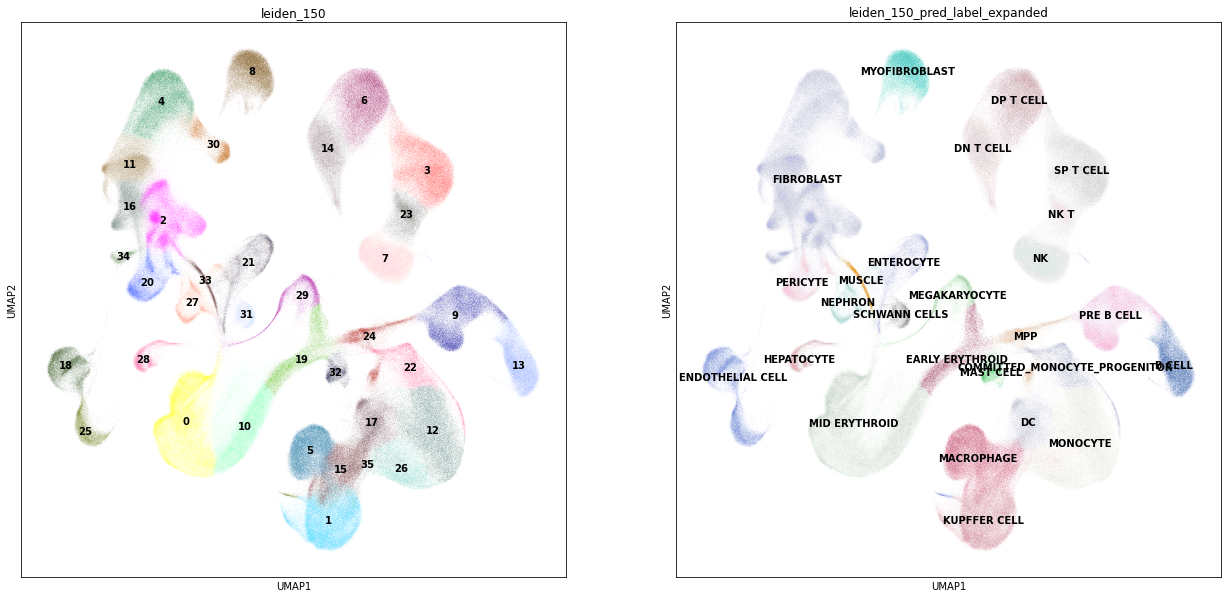

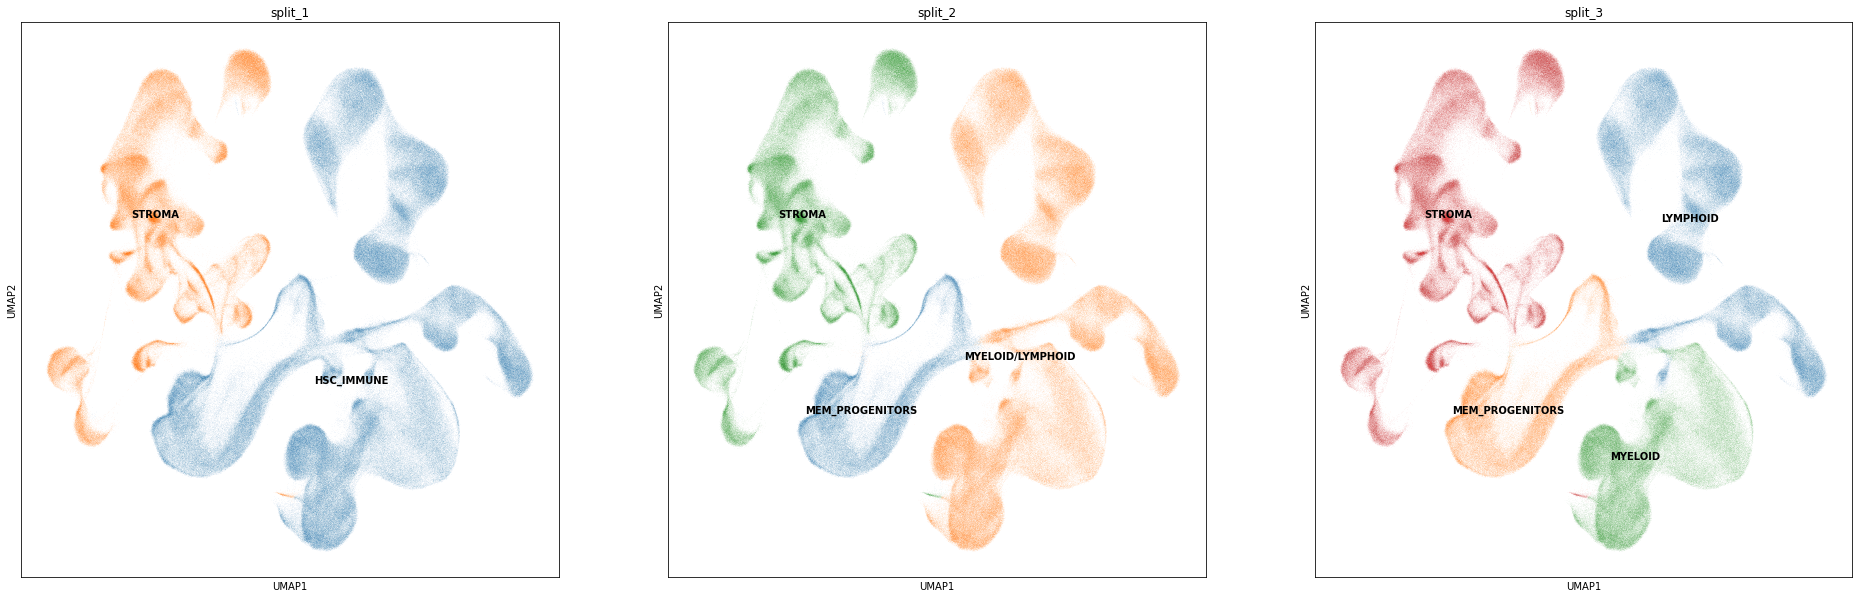

In [19]:
sc.pl.umap(adata, color=["leiden_150", 'leiden_150_pred_label_expanded'], legend_loc="on data")
sc.pl.umap(adata, color=["split_1", "split_2","split_3"], legend_loc="on data")

In [ ]:
# adata.obs[adata.obs.split_3=="B"].value_counts("uniform_label")
split_df = adata.obs.reset_index()[["uniform_label_expanded_merged_propagated", 'split_3','index']] \
    .dropna() \
    .groupby(['split_3', "uniform_label_expanded_merged_propagated"]) \
    .count().fillna(0).reset_index() \
    .pivot(columns=['split_3'], index=["uniform_label_expanded_merged_propagated"])

split_df =split_df[split_df.index!="nan"]

In [ ]:
sns.clustermap((split_df.T/split_df.sum(1)), figsize=[25,5])

### Save clustering output

In [26]:
adata.obs_names = new_obs[new_obs.doublet_scores < 0.4].index

In [27]:
## Save clustering results
adata.obs.to_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118.clustering.obs.csv")

In [28]:
adata.obs

Sample  n_counts  n_genes  \
index                                                                          
FCAImmP7179363-AAACCTGAGCAGATCG                F21_LI_45P   12998.0     2880   
FCAImmP7179363-AAACCTGAGCTGATAA                F21_LI_45P   10751.0     2463   
FCAImmP7179363-AAACCTGAGGGTTTCT                F21_LI_45P    8974.0     2282   
FCAImmP7179363-AAACCTGGTAGAGGAA                F21_LI_45P   36489.0     4863   
FCAImmP7179363-AAACCTGGTCTTTCAT                F21_LI_45P   14104.0     3082   
...                                                   ...       ...      ...   
TTTGGTTTCTTGTTTG-1_Human_colon_16S7985391  F66-FPI-0-SC-1    5406.0     2127   
TTTGTCAAGCCAGTAG-1_Human_colon_16S7985391  F66-FPI-0-SC-1    4618.0     1952   
TTTGTCAGTCCTCTTG-1_Human_colon_16S7985391  F66-FPI-0-SC-1    3179.0     1245   
TTTGTCAGTTTCGCTC-1_Human_colon_16S7985391  F66-FPI-0-SC-1    5080.0     1817   
TTTGTCATCTCCAGGG-1_Human_colon_16S7985391  F66-FPI-0-SC-1    6656.0     2036   

                                          donor organ method  \
index                                                          
FCAImmP7179363-AAACCTGAGCAGATCG             F21    LI   3GEX   
FCAImmP7179363-AAACCTGAGCTGATAA             F21    LI   3GEX   
FCAImmP7179363-AAACCTGAGGGTTTCT             F21    LI   3GEX   
FCAImmP7179363-AAACCTGGTAGAGGAA             F21    LI   3GEX   
FCAImmP7179363-AAACCTGGTCTTTCAT             F21    LI   3GEX   
...                                         ...   ...    ...   
TTTGGTTTCTTGTTTG-1_Human_colon_16S7985391   F66    GU   3GEX   
TTTGTCAAGCCAGTAG-1_Human_colon_16S7985391   F66    GU   3GEX   
TTTGTCAGTCCTCTTG-1_Human_colon_16S7985391   F66    GU   3GEX   
TTTGTCAGTTTCGCTC-1_Human_colon_16S7985391   F66    GU   3GEX   
TTTGTCATCTCCAGGG-1_Human_colon_16S7985391   F66    GU   3GEX   

                                                                                        file  \
index                                                                                          
FCAImmP7179363-AAACCTGAGCAGATCG                                               FCAImmP7179363   
FCAImmP7179363-AAACCTGAGCTGATAA                                               FCAImmP7179363   
FCAImmP7179363-AAACCTGAGGGTTTCT                                               FCAImmP7179363   
FCAImmP7179363-AAACCTGGTAGAGGAA                                               FCAImmP7179363   
FCAImmP7179363-AAACCTGGTCTTTCAT                                               FCAImmP7179363   
...                                                                                      ...   
TTTGGTTTCTTGTTTG-1_Human_colon_16S7985391  cellranger202_count_30328_Human_colon_16S79853...   
TTTGTCAAGCCAGTAG-1_Human_colon_16S7985391  cellranger202_count_30328_Human_colon_16S79853...   
TTTGTCAGTCCTCTTG-1_Human_colon_16S7985391  cellranger202_count_30328_Human_colon_16S79853...   
TTTGTCAGTTTCGCTC-1_Human_colon_16S7985391  cellranger202_count_30328_Human_colon_16S79853...   
TTTGTCATCTCCAGGG-1_Human_colon_16S7985391  cellranger202_count_30328_Human_colon_16S79853...   

                                               mito  doublet_scores  \
index                                                                 
FCAImmP7179363-AAACCTGAGCAGATCG            0.030389        0.049569   
FCAImmP7179363-AAACCTGAGCTGATAA            0.032090        0.181818   
FCAImmP7179363-AAACCTGAGGGTTTCT            0.035324        0.051592   
FCAImmP7179363-AAACCTGGTAGAGGAA            0.042725        0.065513   
FCAImmP7179363-AAACCTGGTCTTTCAT            0.032615        0.060498   
...                                             ...             ...   
TTTGGTTTCTTGTTTG-1_Human_colon_16S7985391  0.006844        0.068966   
TTTGTCAAGCCAGTAG-1_Human_colon_16S7985391  0.018839        0.009174   
TTTGTCAGTCCTCTTG-1_Human_colon_16S7985391  0.006291        0.013185   
TTTGTCAGTTTCGCTC-1_Human_colon_16S7985391  0.011417        0.083906   
TTTGTCATCTCCAGGG-1_Human_colon_16S7985391  0.022236        0.116751   

    

In [30]:
adata_obs = adata.obs.copy()

In [31]:
del adata

In [32]:
import gc
gc.collect()

121

### Split datasets

Load normalized data pre-correction and feature selection

In [ ]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

merged_raw.obs_names = obs_names

In [ ]:
merged_raw = merged_raw[adata.obs_names]

Split based on splits

In [ ]:
save_path = '/nfs/team205/ed6/data/Fetal_immune/'
suffix = 'PAN.A01.v01.entire_data_normalised_log.wGut.batchCorrected_20210118'
split_col = "split_2"

splits = adata_obs[split_col].unique()

In [ ]:
splits

In [ ]:
for s in splits:
    adata_name = save_path + "{}.{}.h5ad".format(suffix, s)
    sdata = merged_raw[adata_obs[split_col]==s]
    print("Saving {} anndata ({} cells, {} organs)".format(s, sdata.obs_names.shape[0], sdata.obs["organ"].unique().shape[0]))
    sdata.write_h5ad(adata_name)